In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import dataset,DataLoader,random_split
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_ds=MNIST(root='/content/drive/My Drive/Datasets/MNIST Dataset/',train=True,transform=ToTensor())
test_ds=MNIST(root='/content/drive/My Drive/Datasets/MNIST Dataset/',train=False,transform=ToTensor())
train_ds,val_ds=random_split(train_ds,[50000,10000])
print('train:',len(train_ds),'\ntest:',len(val_ds),'\nval:',len(test_ds))

train: 50000 
test: 10000 
val: 10000


In [ ]:
batch_size=128
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size,pin_memory=True)

torch.Size([128, 1, 28, 28])


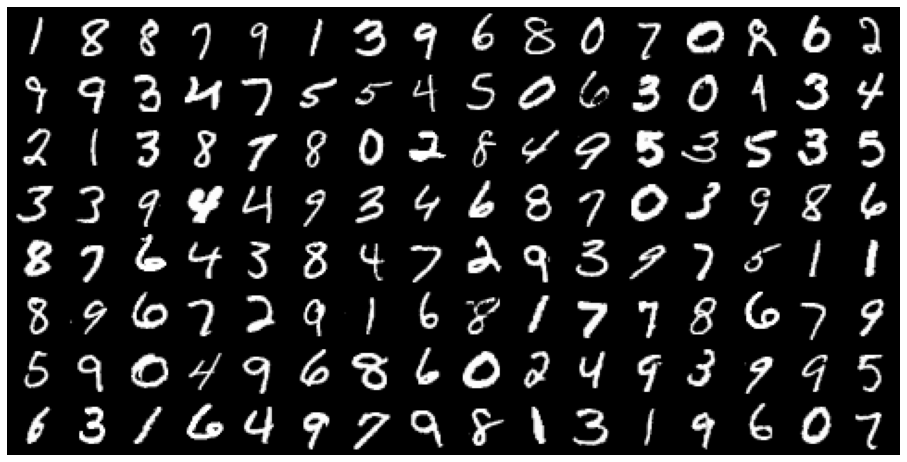

In [ ]:
for x,y in train_dl:
  print(x.shape)
  plt.figure(figsize=(16,10))
  plt.axis('off')
  plt.imshow(make_grid(x, nrow=16).permute((1, 2, 0)))
  break

## Model

In [ ]:
class MNISTmodel(nn.Module):
  def __init__(self,inp,out):
    super().__init__()
    self.inp=inp
    self.out=out
    self.linear1=nn.Linear(self.inp,32)
    self.linear2=nn.Linear(32,16)
    self.linear3=nn.Linear(16,self.out)
  def forward(self,xb):
    xb=xb.reshape(-1,self.inp)
    output=self.linear1(xb)
    xb=F.relu(output)
    output=self.linear2(xb)
    xb=F.relu(output)
    output=self.linear3(xb)
    return output
  def train_step(self,batch):
    xb,label=batch
    output=self(xb)
    loss=F.cross_entropy(output,label)
    return loss
  def accuracy(self,pred,label):
    a,b=torch.max(pred,dim=1)
    return torch.tensor(torch.sum(b==label).item()/label.numel())
  def validate(self,batch):
    img,label=batch
    output=self(img)
    return {'loss':F.cross_entropy(output,label),'accuracy':self.accuracy(output,label)}
  def validate_epoch(self,res_batch):
    li=[x['loss'] for x in res_batch]
    loss=torch.stack(li).mean()
    li1=[x['accuracy'] for x in res_batch]
    accuracy=torch.stack(li1).mean()
    return {'loss':loss.item(),'accuracy':accuracy.item()}
  def epoch_end(self,epoch,res):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, res['loss'], res['accuracy']))
  def evaluate(self,val_dl):
    output=[self.validate(x) for x in val_dl]
    result=self.validate_epoch(output)
    return result
  def fit(self,epochs,train_dl,val_dl,lr,opt_func=torch.optim.SGD):
    history=[]
    opt=opt_func(self.parameters(),lr)
    for epoch in range(epochs):
      for batch in train_dl:
        loss=self.train_step(batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
      result=self.evaluate(val_dl)
      self.epoch_end(epoch,result)
      history.append(result)
    return history
  def predict(self,img):
    return F.softmax(self(img.unsqueeze(0)))

## Auto selecting GPU or CPU based on availability

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl,device):
    self.dl = dl
    self.device = device
        
  def __iter__(self):
    for b in self.dl: 
        yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
device=get_default_device()
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [ ]:
model=MNISTmodel(28*28,10)

In [ ]:
model=to_device(model,device)

In [ ]:
history=[]

In [ ]:
history+=[model.evaluate(val_dl)]
history

[{'accuracy': 0.1083860769867897, 'loss': 2.307645797729492}]

In [ ]:
history+=model.fit(10,train_dl,val_dl,0.5)

Epoch [0], val_loss: 0.3041, val_acc: 0.9077
Epoch [1], val_loss: 0.2373, val_acc: 0.9252
Epoch [2], val_loss: 0.3335, val_acc: 0.8887
Epoch [3], val_loss: 0.1559, val_acc: 0.9529
Epoch [4], val_loss: 0.1333, val_acc: 0.9588
Epoch [5], val_loss: 0.1467, val_acc: 0.9533
Epoch [6], val_loss: 0.1356, val_acc: 0.9584
Epoch [7], val_loss: 0.1236, val_acc: 0.9636
Epoch [8], val_loss: 0.1754, val_acc: 0.9489
Epoch [9], val_loss: 0.1701, val_acc: 0.9493


In [ ]:
history+=model.fit(10,train_dl,val_dl,0.1)

Epoch [0], val_loss: 0.1133, val_acc: 0.9670
Epoch [1], val_loss: 0.1113, val_acc: 0.9676
Epoch [2], val_loss: 0.1131, val_acc: 0.9678
Epoch [3], val_loss: 0.1138, val_acc: 0.9679
Epoch [4], val_loss: 0.1141, val_acc: 0.9681
Epoch [5], val_loss: 0.1143, val_acc: 0.9678
Epoch [6], val_loss: 0.1154, val_acc: 0.9679
Epoch [7], val_loss: 0.1177, val_acc: 0.9665
Epoch [8], val_loss: 0.1163, val_acc: 0.9671
Epoch [9], val_loss: 0.1186, val_acc: 0.9675


In [ ]:
history+=model.fit(10,train_dl,val_dl,0.01)

Epoch [0], val_loss: 0.1168, val_acc: 0.9687
Epoch [1], val_loss: 0.1169, val_acc: 0.9684
Epoch [2], val_loss: 0.1170, val_acc: 0.9685
Epoch [3], val_loss: 0.1172, val_acc: 0.9681
Epoch [4], val_loss: 0.1173, val_acc: 0.9681
Epoch [5], val_loss: 0.1174, val_acc: 0.9679
Epoch [6], val_loss: 0.1177, val_acc: 0.9682
Epoch [7], val_loss: 0.1177, val_acc: 0.9684
Epoch [8], val_loss: 0.1178, val_acc: 0.9683
Epoch [9], val_loss: 0.1177, val_acc: 0.9678


In [ ]:
res1=model.evaluate(val_dl)
res1

{'accuracy': 0.9677610993385315, 'loss': 0.1177489310503006}

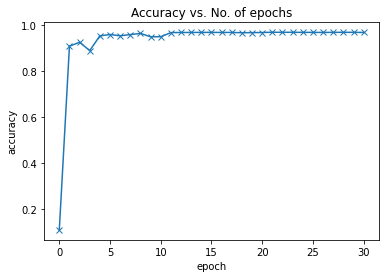

In [ ]:
# Replace these values with your results
accuracies = [i['accuracy'] for i in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
a,b=torch.max(model.predict(test_ds[0][0].to(device)),dim=1)
print(a,b)

tensor([0.9999], device='cuda:0', grad_fn=<MaxBackward0>) tensor([7], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
test_ds[0][1]

7

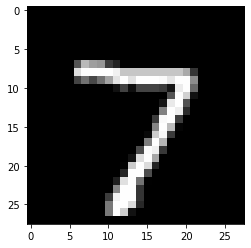

In [ ]:
plt.imshow(test_ds[0][0][0],cmap='gray')

In [ ]:
test_dl=DeviceDataLoader(DataLoader(test_ds,batch_size),device)
model.evaluate(test_dl)

{'accuracy': 0.9696400165557861, 'loss': 0.10540525615215302}

In [ ]:
torch.save(model,'/content/drive/My Drive/DevOps/PyTorch/JupyterNotebooks/04-feedforward-nn/TrainedModel.model')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MNISTmodel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model1=torch.load('/content/drive/My Drive/DevOps/PyTorch/JupyterNotebooks/04-feedforward-nn/TrainedModel.model')

In [ ]:
model1.evaluate(test_dl)

{'accuracy': 0.9696400165557861, 'loss': 0.10540525615215302}